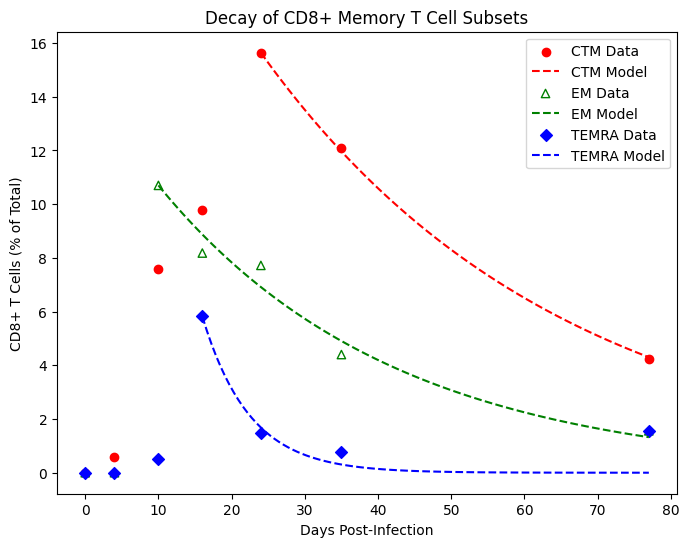

,Initial Peak Value,Decay rate (k),Half-life (days),Estimated Lifespan (days)
CTM,15.64,0.024352,28.463339,85.390018
EM,10.70,0.031192,22.221751,66.665254
TEMRA,5.82,0.155054,4.470349,13.411047


In [6]:
# Given data
data = {
    "Day": [0, 4, 10, 16, 24, 35, 77],
    "CTM": [0.00, 0.57, 7.58, 9.77, 15.64, 12.09, 4.23],
    "EM": [0.00, 0.00, 10.70, 8.18, 7.72, 4.40, 1.56],
    "TEMRA": [0.00, 0.00, 0.51, 5.82, 1.48, 0.77, 1.56]
}

df = pd.DataFrame(data)

# Define exponential decay function
def constrained_exp_decay(t, k, initial_value):
    return initial_value * np.exp(-k * t)

# Dictionary to store refined decay parameters
decay_params_refined = {}

# Define unique colors and markers for each subset
colors = {"CTM": "red", "EM": "green", "TEMRA": "blue"}
markers = {"CTM": "o", "EM": "^", "TEMRA": "D"}

# Create plot
plt.figure(figsize=(8, 6))

for subset in ["CTM", "EM", "TEMRA"]:
    # Extract peak and restrict to post-peak period
    peak_index = np.argmax(df[subset])
    t_fit = np.array(df["Day"][peak_index:])  # Days after peak
    y_fit = np.array(df[subset][peak_index:])  # Cell % after peak
    initial_value = y_fit[0]  # Peak value as the fixed starting point

    # Shift time to start at peak (t=0 at peak)
    t_shifted = t_fit - t_fit[0]

    # Fit the decay curve
    popt, _ = curve_fit(lambda t, k: constrained_exp_decay(t, k, initial_value),
                        t_shifted, y_fit, p0=[0.01], maxfev=5000)
    k_fit = popt[0]
    half_life = np.log(2) / k_fit
    estimated_lifespan = 3 * half_life  # Approximate meaningful presence duration

    # Store results
    decay_params_refined[subset] = {
        "Initial Peak Value": initial_value,
        "Decay rate (k)": k_fit,
        "Half-life (days)": half_life,
        "Estimated Lifespan (days)": estimated_lifespan
    }

    # Scatter plot for observed data
    if subset == "EM":
        plt.scatter(df["Day"], df[subset], label=f"{subset} Data", marker=markers[subset], edgecolor=colors[subset], facecolor='none')
    else:
        plt.scatter(df["Day"], df[subset], label=f"{subset} Data", marker=markers[subset], color=colors[subset])

    # Generate model fit within its fitted period
    t_model = np.linspace(t_fit[0], t_fit[-1], 100)
    plt.plot(t_model, constrained_exp_decay(t_model - t_fit[0], k_fit, initial_value), label=f"{subset} Model", color=colors[subset], linestyle="--")

# Formatting the plot
plt.xlabel("Days Post-Infection")
plt.ylabel("CD8+ T Cells (% of Total)")
plt.title("Decay of CD8+ Memory T Cell Subsets")
plt.legend()
plt.show()

# Convert results to DataFrame and display
decay_df_refined = pd.DataFrame(decay_params_refined).T
decay_df_refined


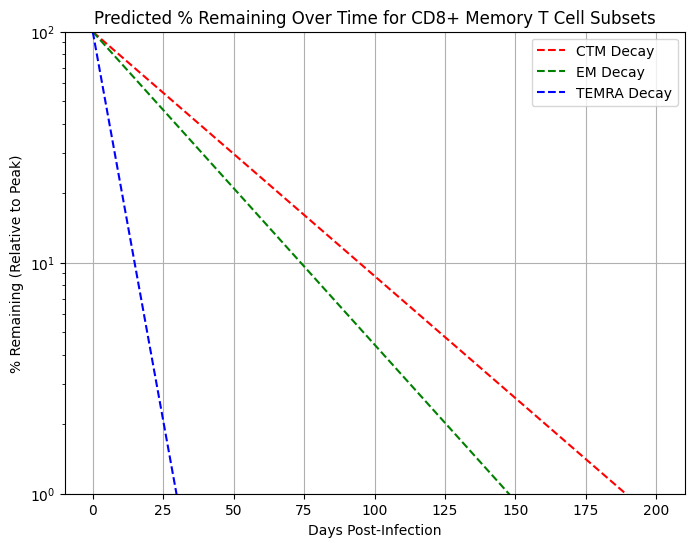

Drop Below 10%:
  Subset  Days Below 10%
0    CTM       94.949495
1     EM       74.747475
2  TEMRA       16.161616

Drop Below 1%:
  Subset  Days Below 1%
0    CTM     189.898990
1     EM     149.494949
2  TEMRA      30.303030


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define time range for prediction
t_pred = np.linspace(0, 200, 100)  # 200 days

# Create plot
plt.figure(figsize=(8, 6))

# Initialize lists to store results
drop_below_10 = []
drop_below_1 = []

for subset, params in decay_params_refined.items():
    k_fit = params["Decay rate (k)"]

    # Predict % remaining (relative to peak)
    y_pred = 100 * np.exp(-k_fit * t_pred)

    # Check when the predicted values drop below 10% and 1%
    days_below_10 = t_pred[y_pred < 10]
    days_below_1 = t_pred[y_pred < 1]

    if len(days_below_10) > 0:
        drop_below_10.append((subset, days_below_10[0]))  # First occurrence
    if len(days_below_1) > 0:
        drop_below_1.append((subset, days_below_1[0]))  # First occurrence

    # Plot the decay curve
    plt.plot(t_pred, y_pred, label=f"{subset} Decay", linestyle="--", color=colors[subset])
    plt.yscale('log')
    plt.ylim(1, 100)

# Formatting the plot
plt.xlabel("Days Post-Infection")
plt.ylabel("% Remaining (Relative to Peak)")
plt.title("Predicted % Remaining Over Time for CD8+ Memory T Cell Subsets")
plt.legend()
plt.grid()

# Display the plot
plt.show()

# Create DataFrame for results
drop_df = pd.DataFrame(drop_below_10, columns=["Subset", "Days Below 10%"])
drop_df_1 = pd.DataFrame(drop_below_1, columns=["Subset", "Days Below 1%"])

# Print results
print("Drop Below 10%:")
print(drop_df)
print("\nDrop Below 1%:")
print(drop_df_1)
